In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [3]:
dataset = datasets.MNIST('data', download = True, transform = transforms.ToTensor())

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size = 128

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

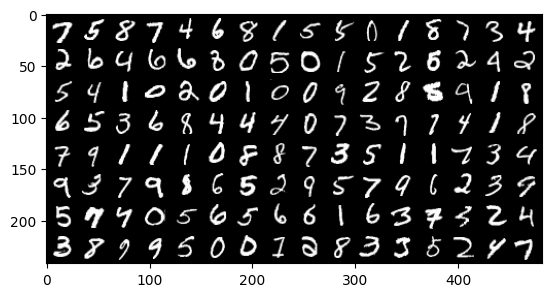

In [ ]:
plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))

In [ ]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hiden_size, out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size, hiden_size)
        #output layer
        self.linear2 = nn.Linear(hiden_size, out_size)

    def forward(self, xb: torch.Tensor):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = nn.ReLU(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [ ]:
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
input_size = 784
hidden_size = 32
num_classes = 10

In [ ]:
model = MnistModel(input_size, hidden_size, out_size = num_classes)

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func =torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader())
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_loader)]
history

TypeError: linear(): argument 'input' (position 1) must be Tensor, not ReLU